# Generazione Cluster per Raccomandazione Videogiochi

**Pipeline**: High Precision / High Silhouette Strategy
- Feature: **Solo `genres`** (colonna `tags` esclusa per ridurre rumore)
- TF-IDF (max_features=1000)
- **TruncatedSVD (n_components=5)**: Dimensionality reduction per massimizzare densità cluster.
- **StandardScaler**: Normalizzazione componenti SVD.
- **K-Means (k=30)**: Clustering ottimizzato.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

## 1. Caricamento Dati

In [2]:
df = pd.read_csv('datasets/steam-games-cleaned.csv')
print(f"Dataset: {len(df):,} giochi")

df['genres'] = df['genres'].fillna('')
if 'tags' not in df.columns:
    df['tags'] = ''
else:
    df['tags'] = df['tags'].fillna('')

Dataset: 42,410 giochi


## 2. Feature Engineering (High Precision)

In [3]:
tfidf = TfidfVectorizer(max_features=1000)
tfidf_matrix = tfidf.fit_transform(df['genres'])

svd = TruncatedSVD(n_components=5, random_state=42)
svd_matrix = svd.fit_transform(tfidf_matrix)

scaler = StandardScaler()
scaled_matrix = scaler.fit_transform(svd_matrix)
print(f"Scaled Matrix Shape: {scaled_matrix.shape}")

Scaled Matrix Shape: (42410, 5)


## 3. Clustering K-Means

In [4]:
N_CLUSTERS = 30
kmeans = KMeans(n_clusters=N_CLUSTERS, init='k-means++', n_init=10, random_state=42)
df['cluster'] = kmeans.fit_predict(scaled_matrix)

sil_score = silhouette_score(scaled_matrix, df['cluster'])
print(f"SILHOUETTE SCORE (High Precision): {sil_score:.4f}")

SILHOUETTE SCORE (High Precision): 0.5683


## 4. Visualizzazione Risultati

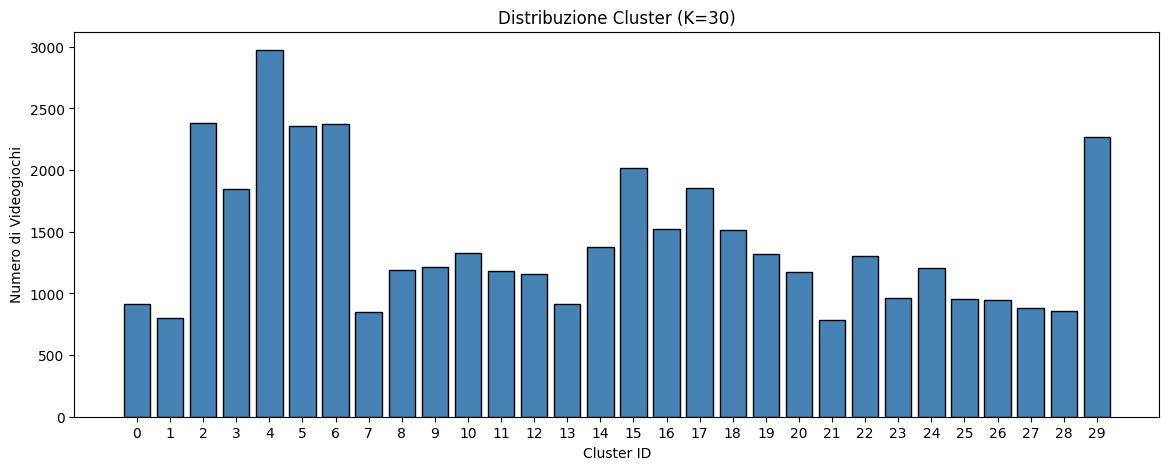

In [5]:
cluster_dist = df['cluster'].value_counts().sort_index()
plt.figure(figsize=(14, 5))
plt.bar(cluster_dist.index.astype(str), cluster_dist.values, color='steelblue', edgecolor='black')
plt.xlabel('Cluster ID')
plt.ylabel('Numero di Videogiochi')
plt.title(f'Distribuzione Cluster (K={N_CLUSTERS})')
plt.show()

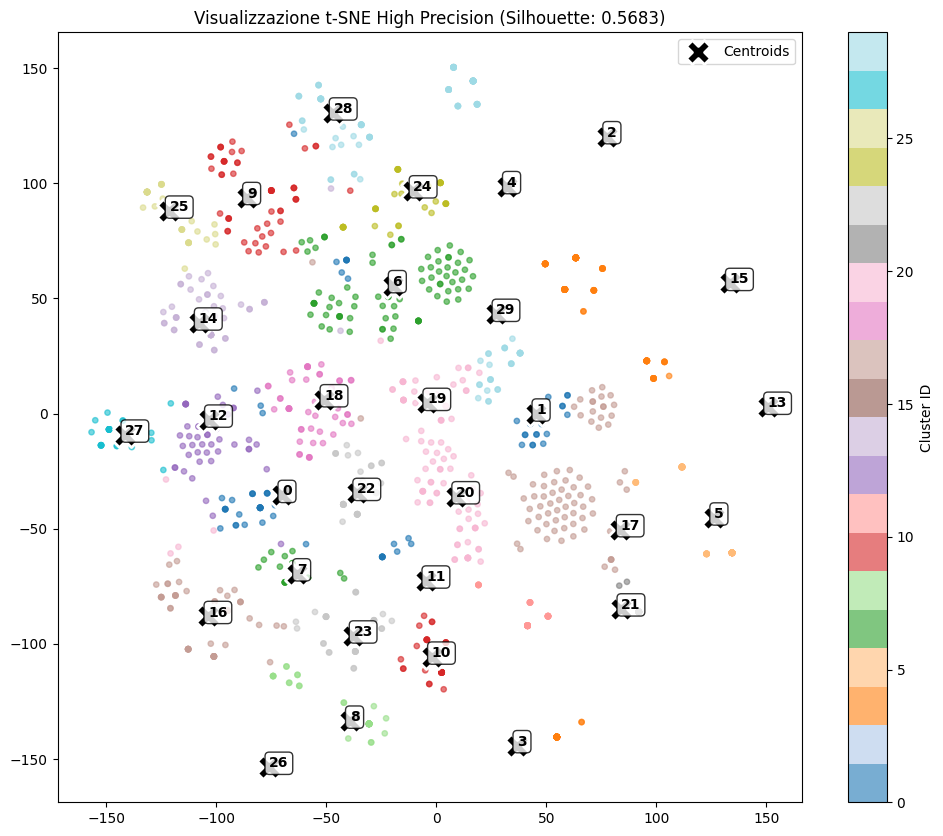

In [6]:
SAMPLE_SIZE = 1500
idx = np.random.choice(len(scaled_matrix), SAMPLE_SIZE, replace=False)
pts_data = scaled_matrix[idx]
ctrs_data = kmeans.cluster_centers_

combined_data = np.vstack([pts_data, ctrs_data])
tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='pca', learning_rate='auto')
tsne_results = tsne.fit_transform(combined_data)

pts = tsne_results[:SAMPLE_SIZE]
ctrs = tsne_results[SAMPLE_SIZE:]

plt.figure(figsize=(12, 10))
scatter = plt.scatter(pts[:, 0], pts[:, 1], c=df['cluster'].iloc[idx], cmap='tab20', alpha=0.6, s=15)
plt.scatter(ctrs[:, 0], ctrs[:, 1], c='black', marker='X', s=300, edgecolor='white', linewidth=2, label='Centroids')

for i, (x, y) in enumerate(ctrs):
    plt.annotate(str(i), (x, y), fontsize=10, fontweight='bold', bbox=dict(boxstyle='round', fc='white', alpha=0.8))

plt.colorbar(scatter, label='Cluster ID')
plt.title(f'Visualizzazione t-SNE High Precision (Silhouette: {sil_score:.4f})')
plt.legend()
plt.show()

## 5. Salvataggio Modello e Risultati

In [7]:
if not os.path.exists('models'):
    os.makedirs('models')

model_data = {
    'dataframe': df,
    'matrix': scaled_matrix,
    'clustering_model': kmeans,
    'tfidf_vectorizer': tfidf,
    'svd': svd,
    'scaler': scaler,
    'optimal_k': N_CLUSTERS,
    'silhouette_score': sil_score,
    'algorithm': 'K-Means (High Precision Strategy)'
}


with open('models/steam_recommender_hp.pkl', 'wb') as f:
    pickle.dump(model_data, f)

print(f"Salvato! K={N_CLUSTERS}, Silhouette={sil_score:.4f}")

Salvato! K=30, Silhouette=0.5683
